<a href="https://colab.research.google.com/github/tomo0530/CS699_Term_Project/blob/master/CS699_Term_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict hits in Japanese Baseball

# Initialization

Mount google drive for file storage.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Install pycaret and xfeat

In [ ]:
!pip install pycaret

In [ ]:
!pip install xfeat

Enable pycaret on colab

In [ ]:
from pycaret.utils import enable_colab
enable_colab()

Install some packages

In [ ]:
import numpy as np
import pandas as pd
from pandas.core.common import random_state
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Markdown
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import VarianceThreshold
from pycaret.classification import *
from xfeat import CountEncoder, TargetEncoder
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

# Preprocessing

Download pre-processed data

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/tomo0530/CS699_Term_Project/master/baseball_info.csv')
df.head()

,totalPitchingCount,B,S,O,b1,b2,b3,pitcher,pitcherHand,batter,batterHand,pitchType,speed,ballX,ballY,y,inning_number,inning_tb,batter_isPitcher,ballWidthLabel,ballHeightLabel,pitch_category,bottomTeam,topTeam,place,minute,hour,day,month,year,day_of_week,day_of_year,pitcher_order,batter_order
0,1,0,0,0,False,False,False,今永 昇太,1,ピレラ,0,ストレート,149.0,17,9,0,1,0,0,1,0,0,7,4,10,0,18,19,6,2020,4,171,1,1
1,2,1,0,0,False,False,False,今永 昇太,1,ピレラ,0,ストレート,149.0,14,8,0,1,0,0,1,0,0,7,4,10,0,18,19,6,2020,4,171,1,1
2,3,1,1,0,False,False,False,今永 昇太,1,ピレラ,0,チェンジアップ,137.0,8,3,0,1,0,0,3,2,2,7,4,10,0,18,19,6,2020,4,171,1,1
3,4,2,1,0,False,False,False,今永 昇太,1,ピレラ,0,スライダー,138.0,21,6,0,1,0,0,1,1,1,7,4,10,0,18,19,6,2020,4,171,1,1
4,5,2,2,0,False,False,False,今永 昇太,1,ピレラ,0,チェンジアップ,136.0,7,5,1,1,0,0,3,1,2,7,4,10,0,18,19,6,2020,4,171,1,1


Split data into train and test

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.34, random_state=123, stratify=df['y'])

Count and Target encoding for categorical features

In [ ]:
# list categorical columns
categorical_columns = [x for x in df.columns if df[x].dtypes == 'object']

# count encoding
count_encoder = CountEncoder(input_cols=categorical_columns)
df_train = count_encoder.fit_transform(df_train)
df_test = count_encoder.transform(df_test)

# target encoding
fold = KFold(n_splits=10, shuffle=True, random_state=123)
target_encoder = TargetEncoder(input_cols=categorical_columns, target_col='y', fold=fold)
df_train = target_encoder.fit_transform(df_train)
df_test = target_encoder.transform(df_test)

# drop original categorical columns
df_train = df_train.drop(categorical_columns, axis=1)
df_train = df_test.drop(categorical_columns, axis=1)

Save train and test data

In [ ]:
df_train.to_csv('/content/drive/MyDrive/CS699_TermProject/train_data.csv', index=False)
df_test.to_csv('/content/drive/MyDrive/CS699_TermProject/test_data.csv', index=False)

Split into objective and explanatory variables

In [ ]:
X_train, y_train = df_train.drop('y', axis=1), df_train['y'].values
X_test, y_test = df_test.drop('y', axis=1), df_test['y'].values

# Classification

### Classifier Comparison

Setup pycaret with all attributes

In [ ]:
clf = setup(data=df_train, target='y', session_id=123,
            categorical_features = ['ballX'],
            numeric_features = ['pitchType_ce'])

Compare 17 classification algorithms below.    
Sorting by MCC because the proportion of "1" (hit) is extremely low.

In [ ]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [ ]:
best_models = compare_models(n_select=5, sort='MCC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9491,0.7173,0.0951,1.0000,0.1720,0.1641,0.2955,0.881
et,Extra Trees Classifier,0.9491,0.7056,0.0951,1.0000,0.1720,0.1641,0.2955,0.842
lightgbm,Light Gradient Boosting Machine,0.9471,0.7441,0.0951,0.7117,0.1665,0.1557,0.2456,0.213
nb,Naive Bayes,0.6161,0.7440,0.7836,0.1062,0.1871,0.0977,0.1824,0.313
dt,Decision Tree Classifier,0.8983,0.5587,0.1761,0.1518,0.1620,0.1086,0.1093,0.080
ada,Ada Boost Classifier,0.9444,0.7395,0.0110,0.3000,0.0212,0.0201,0.0558,0.412
qda,Quadratic Discriminant Analysis,0.5240,0.5393,0.5566,0.0657,0.1171,0.0186,0.0368,0.115
svm,SVM - Linear Kernel,0.9196,0.0000,0.0517,0.0671,0.0276,0.0160,0.0247,0.133
lda,Linear Discriminant Analysis,0.9401,0.7216,0.0071,0.0417,0.0121,0.0042,0.0028,0.174
ridge,Ridge Classifier,0.9438,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.038


Create a function to evaluate classifier using predicted result and actual test data.


In [ ]:
def evaluate_accuracy(y_test, test_pred):
  y_pred = test_pred['Label'].values
  y_test_1 = np.where(y_test == 0, 1, 0)
  test_score = test_pred['Score_1'].values

  prc = classification_report(y_test, y_pred, output_dict=True)
  mc = matthews_corrcoef(y_test, y_pred)
  roc_area = roc_auc_score(y_test, test_score)
  precision, recall, _ = precision_recall_curve(y_test, test_score)
  precision_1, recall_1, _ = precision_recall_curve(y_test_1, test_score)
  prc_area = auc(recall, precision) 
  prc_area_1 = auc(recall_1, precision_1)
  prc_area_ave = (prc['0']['support'] * prc_area + prc['1']['support'] * prc_area_1) / prc['weighted avg']['support']

  cls = ['0', '1', 'Weighted Avg.']
  tpr = [prc['0']['recall'], prc['1']['recall'], prc['weighted avg']['recall']]
  fpr = [1 - tpr[i] for i in range(len(tpr))]
  pre = [prc['0']['precision'], prc['1']['precision'], prc['weighted avg']['precision']]
  rec = tpr
  fm = [prc['0']['f1-score'], prc['1']['f1-score'], prc['weighted avg']['f1-score']]
  mcc = [mc, mc, mc]
  roc = [roc_area, roc_area, roc_area]
  prc = [prc_area, prc_area_1, prc_area_ave]
  
  data = {
            'Class': cls,
            'TP Rate': tpr,
            'FP Rate': fpr,
            'Precision': pre,
            'Recall': rec,
            'F-Measure': fm,
            'MCC': mcc,
            'ROC Area': roc,
            'PRC Area': prc
        }
  
  return pd.DataFrame(data)

Using the top 5 classifiers obtained from the classifier comparison above, create a function for tuning with training data, making predictions from test data, and evaluating prediction results.

In [ ]:
def evaluate_each_clf_accuracy(df_train, X_test, y_test, optimize='Accuracy'):
  clf_dict = {'rf':	'Random Forest Classifier',
              'et': 'Extra Trees Classifier',
              'lightgbm':	'Light Gradient Boosting Machine',
              'nb':	'Naive Bayes',
              'dt':	'Decision Tree Classifier'}

  original_list_c = ['ballX']
  original_list_n = ['pitchType_ce']
  c_list = [i for i in df_train.columns if i in original_list_c]
  n_list = [i for i in df_train.columns if i in original_list_n]
  clf = setup(data=df_train, target='y', session_id=123, 
              categorical_features = c_list, 
              numeric_features = n_list, silent = True)  
  
  df = pd.DataFrame()
  for model, name in clf_dict.items():
    m = create_model(model)
    tuned_m = tune_model(m, optimize=optimize)
    final_m = finalize_model(tuned_m)
    test_pred = predict_model(final_m, data=X_test, raw_score=True)
    df_new = evaluate_accuracy(y_test, test_pred)
    df_new['Model'] = name
    df = pd.concat([df, df_new])
  
  return df.set_index(["Model", "Class"])

In [ ]:
df_eval = evaluate_each_clf_accuracy(df_train, X_test, y_test, optimize='MCC')

In [ ]:
style = (df_eval.style.highlight_min(color="green").highlight_max(color="red"))  
display(style)

### Classifier Evaluation

Tune the best algorithm and Evaluate the training result by some plots.

In [ ]:
tuned_model = tune_model(best_models[2], optimize='MCC')

In [ ]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

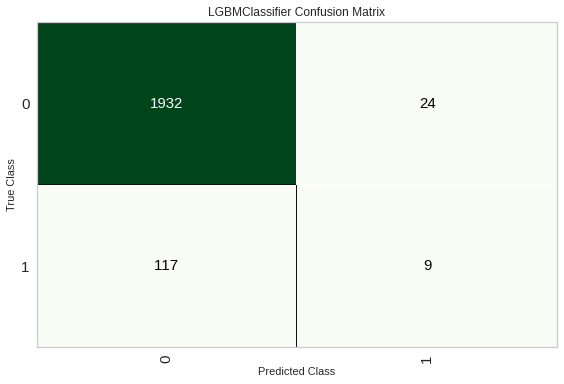

In [ ]:
plot_model(tuned_model, plot='confusion_matrix')

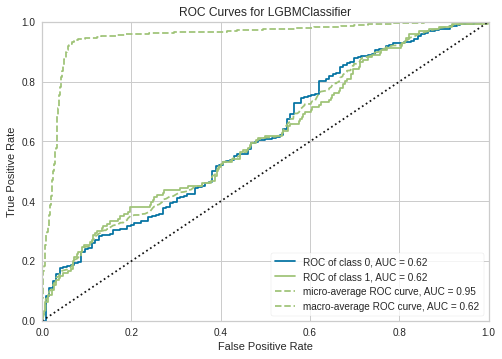

In [ ]:
plot_model(tuned_model, plot='auc')

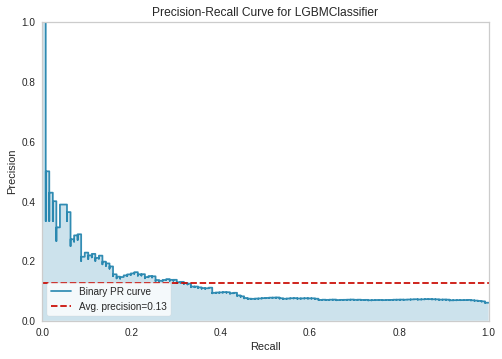

In [ ]:
plot_model(tuned_model, plot='pr')

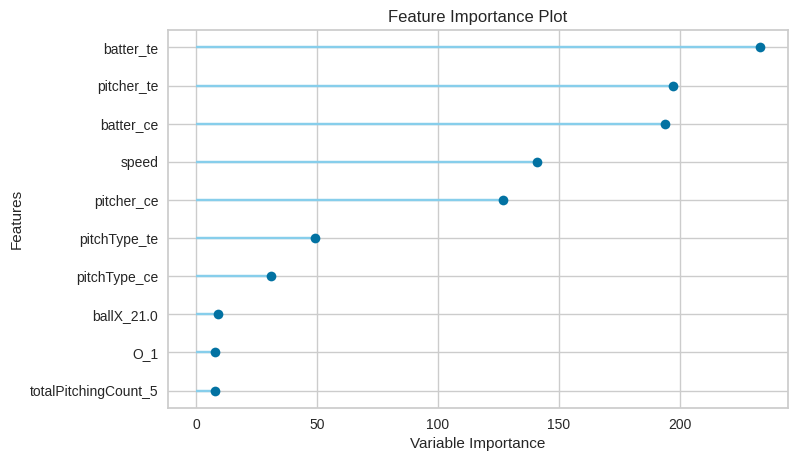

In [ ]:
plot_model(tuned_model, plot='feature')

# Attribute selection method

Set the number to select attributes.

In [ ]:
k = 5

## Filter method
Filter methods pick up the intrinsic properties of the features measured via univariate statistics instead of cross-validation performance. 

### Chi-squared test
The Chi-square test is used for categorical features in a dataset. We calculate Chi-square between each feature and the target and select the desired number of features with the best Chi-square scores.

In [ ]:
selector = SelectKBest(chi2, k=k)
selector.fit_transform(X_train, y_train)
new_col1 = X_train.columns[selector.get_support()]
print('Selected attribute: ', new_col1.to_list())

Selected attribute:  ['totalPitchingCount', 'B', 'pitcher_ce', 'batter_ce', 'pitchType_ce']


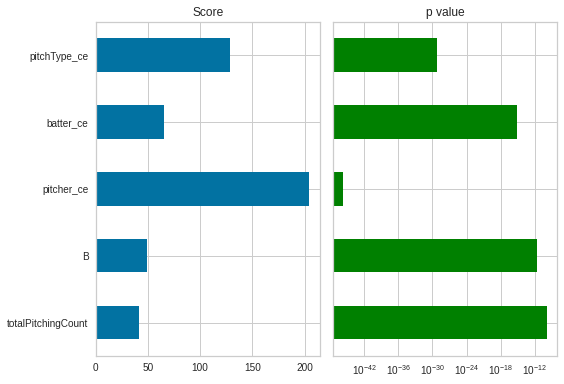

In [ ]:
result1 = pd.DataFrame(selector.scores_, index=X_train.columns.values, columns=['score'])
result1['pvalue'] = selector.pvalues_
result1 = result1.sort_values('score', ascending=True)
result1 = result1.loc[new_col1.to_list()]

fig, axes = plt.subplots(nrows=1, ncols=2)
result1['score'].plot.barh(ax=axes[0], stacked=True, y=[0, 1])
result1['pvalue'].plot.barh(ax=axes[1], color='green')
axes[0].set_title('Score')
axes[1].set_yticklabels([])
axes[1].set_xscale("log")
axes[1].set_title('p value')
fig.tight_layout()
plt.show()

In [ ]:
df_train_new = X_train[new_col1]
df_train_new['y'] = df_train['y']
X_test_new = X_test[new_col1]
df_eval1 = evaluate_each_clf_accuracy(df_train_new, X_test_new, y_test, optimize='MCC')

In [ ]:
style = (df_eval1.style.highlight_min(color="green").highlight_max(color="red"))  
display(style)

### ANOVA
Analysis of Variance (ANOVA) is a statistical method, used to check the means of two or more groups that are significantly different from each other. 

In [ ]:
selector = SelectKBest(f_classif, k=k)
selector.fit_transform(X_train, y_train)
new_col2 = X_train.columns[selector.get_support()]
print('Selected attribute: ', new_col2.to_list())

Selected attribute:  ['totalPitchingCount', 'B', 'S', 'pitcher_ce', 'pitchType_te']


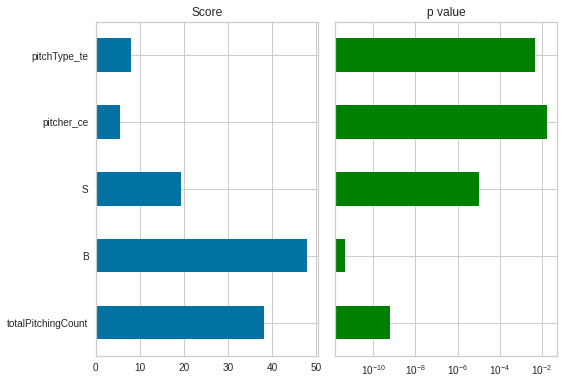

In [ ]:
result2 = pd.DataFrame(selector.scores_, index=X_train.columns.values, columns=['score'])
result2['pvalue'] = selector.pvalues_
result2 = result2.sort_values('score', ascending=True)
result2 = result2.loc[new_col2.to_list()]

fig, axes = plt.subplots(nrows=1, ncols=2)
result2['score'].plot.barh(ax=axes[0], stacked=True, y=[0, 1])
result2['pvalue'].plot.barh(ax=axes[1], color='green')
axes[0].set_title('Score')
axes[1].set_yticklabels([])
axes[1].set_xscale("log")
axes[1].set_title('p value')
fig.tight_layout()
plt.show()

In [ ]:
df_train_new = X_train[new_col2]
df_train_new['y'] = df_train['y']
X_test_new = X_test[new_col2]
df_eval2 = evaluate_each_clf_accuracy(df_train_new, X_test_new, y_test, optimize='MCC')

In [ ]:
style = (df_eval2.style.highlight_min(color="green").highlight_max(color="red"))  
display(style)

### Information Gain
Information gain calculates the reduction in entropy from the transformation of a dataset. It can be used for feature selection by evaluating the Information gain of each variable in the context of the target variable.

In [ ]:
selector = SelectKBest(mutual_info_classif, k=k)
selector.fit_transform(X_train, y_train)
new_col3 = X_train.columns[selector.get_support()]
print('Selected attribute: ', new_col3.to_list())

Selected attribute:  ['totalPitchingCount', 'ballX', 'ballY', 'place', 'pitcher_ce']


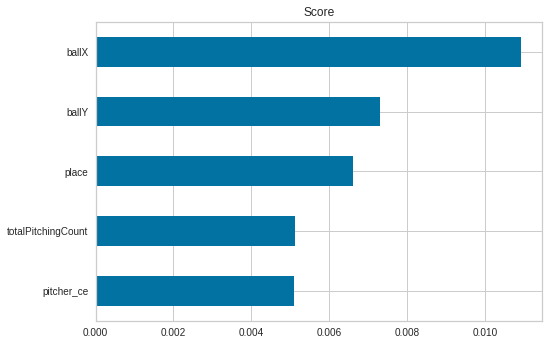

In [ ]:
result3 = pd.DataFrame(selector.scores_, index=X_train.columns.values, columns=['score'])
result3 = result3.loc[new_col3.to_list()]
result3 = result3.sort_values('score', ascending=True)

result3['score'].plot.barh()
plt.title('Score')
plt.show()

In [ ]:
df_train_new = X_train[new_col3]
df_train_new['y'] = df_train['y']
X_test_new = X_test[new_col3]
df_eval3 = evaluate_each_clf_accuracy(df_train_new, X_test_new, y_test, optimize='MCC')

In [ ]:
style = (df_eval3.style.highlight_min(color="green").highlight_max(color="red"))  
display(style)

## Wrapper method
Wrappers require some method to search the space of all possible subsets of features, assessing their quality by learning and evaluating a classifier with that feature subset. The feature selection process is based on a specific machine learning algorithm that we are trying to fit on a given dataset. It follows a greedy search approach by evaluating all the possible combinations of features against the evaluation criterion.

### RFE (Recursive Feature Elimination)
The Recursive Feature Elimination (or RFE) works by recursively removing attributes and building a model on those attributes that remain. It uses the model accuracy to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute.

Remove attributes with variance of 0

In [ ]:
sel = VarianceThreshold()
X = pd.DataFrame(sel.fit_transform(X_train), columns=X_train.columns.values[sel.get_support()])

Use Random Forest as evaluation classifier

In [ ]:
rf = RandomForestClassifier()
selector = RFE(rf, n_features_to_select=k)
selector.fit_transform(X, y_train)
new_col4 = X.columns[selector.get_support()]
print('Selected attribute: ', new_col4.to_list())

Selected attribute:  ['speed', 'ballX', 'batter_ce', 'pitcher_te', 'batter_te']


In [ ]:
df_train_new = X_train[new_col4]
df_train_new['y'] = df_train['y']
X_test_new = X_test[new_col4]
df_eval4 = evaluate_each_clf_accuracy(df_train_new, X_test_new, y_test, optimize='MCC')

In [ ]:
style = (df_eval4.style.highlight_min(color="green").highlight_max(color="red"))  
display(style)

## Embedded method
Embedded methods encompass the benefits of both the wrapper and filter methods, by including interactions of features but also maintaining reasonable computational cost. These methods are iterative in the sense that takes care of each iteration of the model training process and carefully extracts those features which contribute the most to the training for a particular iteration.

### LASSO Regularization (L1)
Regularization consists of adding a penalty to the different parameters of the machine learning model to reduce the freedom of the model, i.e. to avoid over-fitting. In linear model regularization, the penalty is applied over the coefficients that multiply each of the predictors. From the different types of regularization, Lasso or L1 has the property that is able to shrink some of the coefficients to zero. Therefore, that feature can be removed from the model.

Standardize training data

In [ ]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)

Use Logistic regression as evaluation classifier

In [ ]:
lr = LogisticRegression(C=1, penalty="l1", solver='liblinear')
selector = SelectFromModel(estimator=lr, max_features=k).fit(X_train_scale, y_train)
new_col5 = X_train.columns[selector.get_support()]
print('Selected attribute: ', new_col5.to_list())

Selected attribute:  ['totalPitchingCount', 'B', 'S', 'ballY', 'pitcher_ce']


In [ ]:
df_train_new = X_train[new_col5]
df_train_new['y'] = df_train['y']
X_test_new = X_test[new_col5]
df_eval5 = evaluate_each_clf_accuracy(df_train_new, X_test_new, y_test, optimize='MCC')

In [ ]:
style = (df_eval5.style.highlight_min(color="green").highlight_max(color="red"))  
display(style)

# Conclusion

Plot the attribute selection method results

In [ ]:
methods=['All attributes',
         'Filter method(Chi2)', 
         'Filter method(ANOVA)',
         'Filter method(Info gain)',
         'Wrapper method(RFE)',
         'Embedded method(LASSO)']
clfs = ['Random Forest Classifier',
        'Extra Trees Classifier',
        'Light Gradient Boosting Machine',
        'Naive Bayes',
        'Decision Tree Classifier']

y1, y2, y3, y4, y5 = [], [], [], [], []
y_list = [y1, y2, y3, y4, y5]
for y, clf in zip(y_list, clfs):
  y.append(df_eval.loc[(clf, 'Weighted Avg.')]['MCC'])
  y.append(df_eval1.loc[(clf, 'Weighted Avg.')]['MCC'])
  y.append(df_eval2.loc[(clf, 'Weighted Avg.')]['MCC'])
  y.append(df_eval3.loc[(clf, 'Weighted Avg.')]['MCC'])
  y.append(df_eval4.loc[(clf, 'Weighted Avg.')]['MCC'])
  y.append(df_eval5.loc[(clf, 'Weighted Avg.')]['MCC'])

fig = go.Figure(data=[
    go.Bar(name=clfs[0], x=methods, y=y1),
    go.Bar(name=clfs[1], x=methods, y=y2),
    go.Bar(name=clfs[2], x=methods, y=y3),
    go.Bar(name=clfs[3], x=methods, y=y4),
    go.Bar(name=clfs[4], x=methods, y=y5)])
fig.update_layout(title="Bar chart of each attribute selection method's MCC",
                  yaxis=dict(title='MCC'),
                  barmode='group')
fig.show()

Save train and test data that were used for the best model.

In [ ]:
new_col_best = new_col4
df_train_new = X_train[new_col_best]
X_test_new = X_test[new_col_best]

df_train_new.to_csv('/content/drive/MyDrive/CS699_TermProject/train_data_best.csv', index=False)
X_test_new.to_csv('/content/drive/MyDrive/CS699_TermProject/test_data_best.csv', index=False)